In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import os
import time
import numpy as np
import pandas as pd

from os import listdir
from io import BytesIO
import requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,utils
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from scipy import stats
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import PIL
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [4]:
DATA_DIR = 'data/caps and shoes/'

In [5]:
def convert_img_to_data(image):
    data = np.asarray(image)
    gs_image = image.convert(mode='L')
    gs_data = np.asarray(gs_image)
    gs_resized = gs_image.resize((112,112))
    gs_resized_data = np.asarray(gs_resized)
    reshaped_gs_data = gs_resized_data.reshape(112*112)
    return reshaped_gs_data

def convert_images_from_dir(dir_path):
    image_data = []
    
    for filename in listdir(dir_path):
        image = Image.open(dir_path +os.sep + filename)
        reshaped_gs_data = convert_img_to_data(image)
        image_data.append(reshaped_gs_data)
    
    return image_data

def load_from_dir(dir_path, labels):
    label_data = []
    image_data = []
    for label in labels:
        data_from_dir = convert_images_from_dir(dir_path + label)
        labels_for_data = [label for i in range(len(data_from_dir))]
        image_data += data_from_dir
        label_data += labels_for_data
    
    print('Found %d images belonging to %d classes' % (len(image_data),  len(labels)))
    return (np.array(image_data),np.array(label_data))

def load_img_data(data_dir):
    train_dir = DATA_DIR + 'train/'
    validation_dir = DATA_DIR + 'val/'
    test_dir = DATA_DIR + 'test/'
    
    if (os.path.isdir(train_dir) and os.path.isdir(validation_dir) and os.path.isdir(test_dir)) :
        labels = [subdirname.name for subdirname in os.scandir(train_dir) if subdirname.is_dir()] 
        
        train_data = load_from_dir(train_dir,labels)
        validation_data = load_from_dir(validation_dir,labels)
        test_data = load_from_dir(test_dir,labels)
        
    return train_data, validation_data, test_data     

def url_to_image(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    return img

def plot_images(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        
        plt.imshow(ims[i].reshape(112,112), cmap="gray")

In [6]:
train_data, validation_data, test_data = load_img_data(DATA_DIR)
X_train, y_train = train_data
X_val, y_val = validation_data
X_test, y_test = test_data

Found 200 images belonging to 2 classes
Found 100 images belonging to 2 classes
Found 50 images belonging to 2 classes


In [7]:
print('X_train shape : %s' % str(X_train.shape))
print('y_train shape : %s' % str(y_train.shape))
print('X_val shape : %s' % str(X_val.shape))
print('y_val shape : %s' % str(y_val.shape))
print('X_test shape : %s' % str(X_test.shape))
print('y_test shape : %s' % str(y_test.shape))

X_train shape : (200, 12544)
y_train shape : (200,)
X_val shape : (100, 12544)
y_val shape : (100,)
X_test shape : (50, 12544)
y_test shape : (50,)


In [8]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [9]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

In [10]:
print('y_train shape : %s' % str(y_train.shape))
print('y_val shape : %s' % str(y_val.shape))
print('y_test shape : %s' % str(y_test.shape))

y_train shape : (200, 2)
y_val shape : (100, 2)
y_test shape : (50, 2)


In [11]:
def define_multilayer_model_architecture():
    model = models.Sequential()
    model.add(Dense(32, activation='relu', input_shape=(12544,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
ITER = 5
total_training_time = 0.0
total_test_accuracy = 0.0
for iter_count in range(ITER):
    model = define_multilayer_model_architecture()
    start_time = time.time()
    model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=125, batch_size=200, verbose=0, shuffle=True)
    training_time = time.time() - start_time
    total_training_time += training_time
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=50)
    total_test_accuracy += test_accuracy

print('Avg training time : %.3f s' % (total_training_time/ITER))
print('Avg test accuracy : %.4f' % (total_test_accuracy/ITER))
print('Total parameters : %d' % model.count_params())

W0805 22:48:21.309348 139944847402816 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


50/50 [==============================] - 0s 334us/sample - loss: 0.5218 - accuracy: 0.7200
Avg training time : 1.446 s
Avg test accuracy : 0.7040
Total parameters : 402002


In [13]:
def define_singlelayer_model_architecture(no_of_neurons=512):
    model = models.Sequential()
    model.add(Dense(no_of_neurons, activation='relu', input_shape=(12544,)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
ITER = 5
total_training_time = 0.0
total_test_accuracy = 0.0
for iter_count in range(ITER):
    model = define_singlelayer_model_architecture()
    start_time = time.time()
    model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=125, batch_size=200, verbose=0, shuffle=True)
    training_time = time.time() - start_time
    total_training_time += training_time
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=50)
    total_test_accuracy += test_accuracy

print('Avg training time : %.3f s' % (total_training_time/ITER))
print('Avg test accuracy : %.4f' % (total_test_accuracy/ITER))
print('Total parameters : %d' % model.count_params())

50/50 [==============================] - 0s 501us/sample - loss: 0.5448 - accuracy: 0.7000
Avg training time : 4.996 s
Avg test accuracy : 0.7280
Total parameters : 6424066


CPU times: user 2.73 s, sys: 43.9 ms, total: 2.77 s
Wall time: 1.17 s


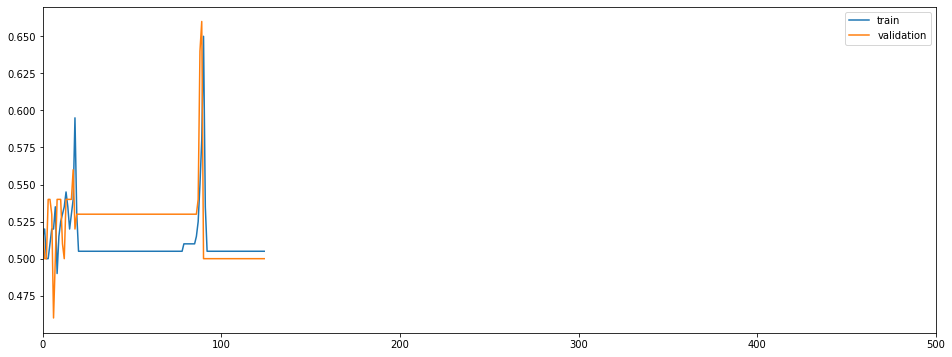

In [15]:
model = define_singlelayer_model_architecture(16)
%time history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=125, batch_size=200, verbose=0, shuffle=True)

plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlim(0, 500)
plt.show()

In [16]:
no_of_neurons = [2**i for i in range(1,11)] + [1024*i for i in range(2,8)]
ITER = 5

for neurons in no_of_neurons:
    total_training_time = 0.0
    total_test_accuracy = 0.0
    for iter_count in range(ITER):
        model = define_singlelayer_model_architecture(neurons)
        start_time = time.time()
        model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=125, batch_size=200, verbose=0, shuffle=True)
        training_time = time.time() - start_time
        total_training_time += training_time
        test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=50, verbose=0)
        total_test_accuracy += test_accuracy
    
    print('No. of neurons : %d' % neurons)
    print('Avg training time : %.3f s' % (total_training_time/ITER))
    print('Avg test accuracy : %.4f' % (total_test_accuracy/ITER))
    print('Total parameters : %d' % model.count_params())

No. of neurons : 2
Avg training time : 1.160 s
Avg test accuracy : 0.5840
Total parameters : 25096
No. of neurons : 4
Avg training time : 1.182 s
Avg test accuracy : 0.5640
Total parameters : 50190
No. of neurons : 8
Avg training time : 1.128 s
Avg test accuracy : 0.6840
Total parameters : 100378
No. of neurons : 16
Avg training time : 1.146 s
Avg test accuracy : 0.6600
Total parameters : 200754
No. of neurons : 32
Avg training time : 1.259 s
Avg test accuracy : 0.7280
Total parameters : 401506
No. of neurons : 64
Avg training time : 1.816 s
Avg test accuracy : 0.7440
Total parameters : 803010
No. of neurons : 128
Avg training time : 2.430 s
Avg test accuracy : 0.7040
Total parameters : 1606018
No. of neurons : 256
Avg training time : 3.679 s
Avg test accuracy : 0.6720
Total parameters : 3212034
No. of neurons : 512
Avg training time : 6.167 s
Avg test accuracy : 0.6680
Total parameters : 6424066
No. of neurons : 1024
Avg training time : 11.705 s
Avg test accuracy : 0.6000
Total parame